In [535]:
import math
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load model along with train-test data

In [170]:
import metbio1dnet
model = metbio1dnet.MetaBioClassifier1D()

model.load_weights('../models/1dcnn_model.weights.h5')

In [ ]:
X_train = pd.read_csv('../files/X_train.csv')
Y_train = pd.read_csv('../files/Y_train.csv')
X_test = pd.read_csv('../files/X_test.csv')
Y_test = pd.read_csv('../files/Y_test.csv')

In [172]:
X_train_array = X_train.to_numpy()
Y_train = Y_train.to_numpy
X_test_array = X_test.to_numpy()
Y_test = Y_test.to_numpy

## Use SHAP Permuations to extract important features

### SHAP: SHapley Additive exPlanations
SHAP is a package which can be used to explain the output of any machine learning model

### Permutation explainer
- Permutation explainer works by randomly permuting feature values and measures the impact on model predictions.
- While being computationally heavy than alternative SHAP explainers, Permut explainer is useful when the relationship between features and predictions is complex or non-linear.

In [ ]:
# Use test data to see impact on model using permutations
explainer_p = shap.explainers.Permutation(model.predict, X_test)

# Extract Shapley values from explainer
shap_values_p = explainer_p(X_test)

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
232/232 ━━━━━━━

PermutationExplainer explainer:  54%|█████▍    | 19/35 [00:00<?, ?it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


PermutationExplainer explainer:  60%|██████    | 21/35 [00:10<00:03,  3.99it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


PermutationExplainer explainer:  63%|██████▎   | 22/35 [00:11<00:04,  2.73it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


PermutationExplainer explainer:  66%|██████▌   | 23/35 [00:12<00:05,  2.37it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  69%|██████▊   | 24/35 [00:12<00:05,  2.16it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


PermutationExplainer explainer:  71%|███████▏  | 25/35 [00:13<00:04,  2.11it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


PermutationExplainer explainer:  74%|███████▍  | 26/35 [00:13<00:04,  2.06it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


PermutationExplainer explainer:  77%|███████▋  | 27/35 [00:14<00:04,  1.89it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


PermutationExplainer explainer:  80%|████████  | 28/35 [00:14<00:03,  1.91it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


PermutationExplainer explainer:  83%|████████▎ | 29/35 [00:15<00:03,  1.93it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


PermutationExplainer explainer:  86%|████████▌ | 30/35 [00:15<00:02,  1.94it/s]

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


PermutationExplainer explainer:  89%|████████▊ | 31/35 [00:16<00:02,  1.96it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step


PermutationExplainer explainer:  91%|█████████▏| 32/35 [00:16<00:01,  1.90it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


PermutationExplainer explainer:  94%|█████████▍| 33/35 [00:17<00:01,  1.92it/s]

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


PermutationExplainer explainer:  97%|█████████▋| 34/35 [00:17<00:00,  1.96it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


PermutationExplainer explainer: 100%|██████████| 35/35 [00:18<00:00,  1.96it/s]

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


PermutationExplainer explainer: 36it [00:18,  1.10s/it]                        


In [192]:
metabolite_names = X_test.columns
metabolite_names

Index(['Age', 'Creatinine', 'Glycine', 'Alanine', 'Serine', 'Proline',
       'Valine', 'Threonine', 'Taurine', 'Putrescine',
       ...
       'Decadienoylcarnitine', 'Decenoylcarnitine', 'Decanoylcarnitine',
       'Dodecenoylcarnitine', 'Dodecanoylcarnitine', 'Hexadecanoylcarnitine',
       'Octadecadienylcarnitine', 'Octadecenoylcarnitine', 'Sex_Female',
       'Sex_Male'],
      dtype='object', length=110)

In [349]:
print("Original Shape:", shap_values_p.shape, "\nshapley values for 35 samples for 110 metabolites (features in this case) for 2 classes 0, 1 (control, covid)")

mean_abs_shap_values = np.mean(np.abs(shap_values_p.values), axis=0)
print("\nCalculating Mean across samples :", mean_abs_shap_values.shape, "\nMean absolute shapley values for 110 metabolites for 2 classes 0, 1")

max_shap_values = np.max(mean_abs_shap_values, axis=1)
print("\nTaking max from 2 classes :", max_shap_values.shape, "\nMax mean absolute shapley values for 110 metabolites")

Original Shape: (35, 110, 2) 
shapley values for 35 samples for 110 metabolites (features in this case) for 2 classes 0, 1 (control, covid)

Calculating Mean across samples : (110, 2) 
Mean absolute shapley values for 110 metabolites for 2 classes 0, 1

Taking max from 2 classes : (110,) 
Max mean absolute shapley values for 110 metabolites


## Top aggregated features

In [350]:
# Converting to dataframe for ease
max_shap_dataset = pd.DataFrame({
    "metabolite": shap_values_p.feature_names,
    "shap": max_shap_values
})

# Pulling top 20 based on aggregated shap values
top_max_shap_dataset = max_shap_dataset.sort_values(by='shap', ascending=False).head(20)

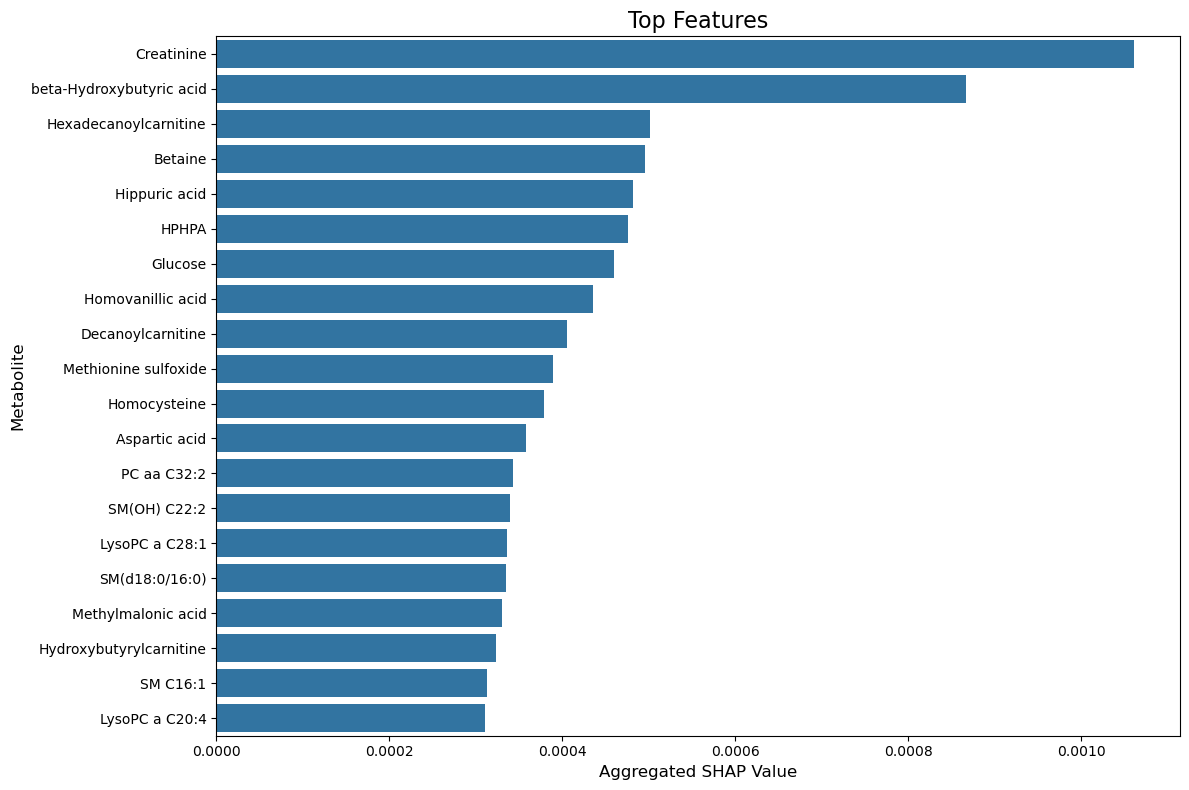

In [351]:
# Create the grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=max_shap_dataset.sort_values(by='shap', ascending=False).head(20), y='metabolite', x='shap')

plt.title('Top Features', fontsize=16)
plt.xlabel('Aggregated SHAP Value', fontsize=12)
plt.ylabel('Metabolite', fontsize=12)

plt.tight_layout()
plt.show()

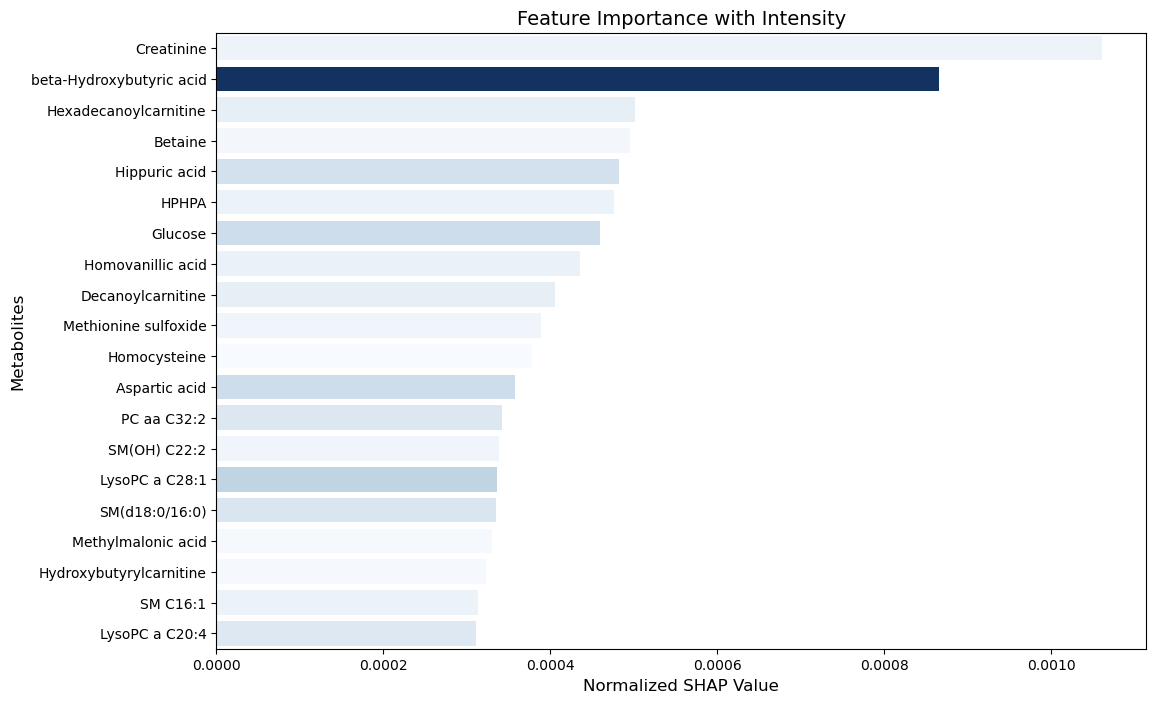

In [369]:
# Plot the same graph with intensity
# Normalize importance values for color intensity (0 to 1)
norm_importance = (max_shap_dataset["shap"] - max_shap_dataset["shap"].min()) / (max_shap_dataset["shap"].max() - max_shap_dataset["shap"].min())
cmap = plt.get_cmap("Blues")
plt.figure(figsize=(12, 8))
sns.barplot(
    x="shap", 
    y="metabolite", 
    data=top_max_shap_dataset, 
    palette=list(cmap(norm_importance[:20])),
    hue = "metabolite"
)

plt.xlabel("Normalized SHAP Value", fontsize=12)
plt.ylabel("Metabolites", fontsize=12)
plt.title("Feature Importance with Intensity", fontsize=14)
plt.show()

## SHAP Waterfall

In [ ]:
# # Use explaination function to explain the values based on features
# explanation_p_0 = shap.Explanation(shap_values_p[0, :, 0], feature_names=metabolite_names)
# shap.waterfall_plot(explanation_p_0.mean(0), max_display=21)

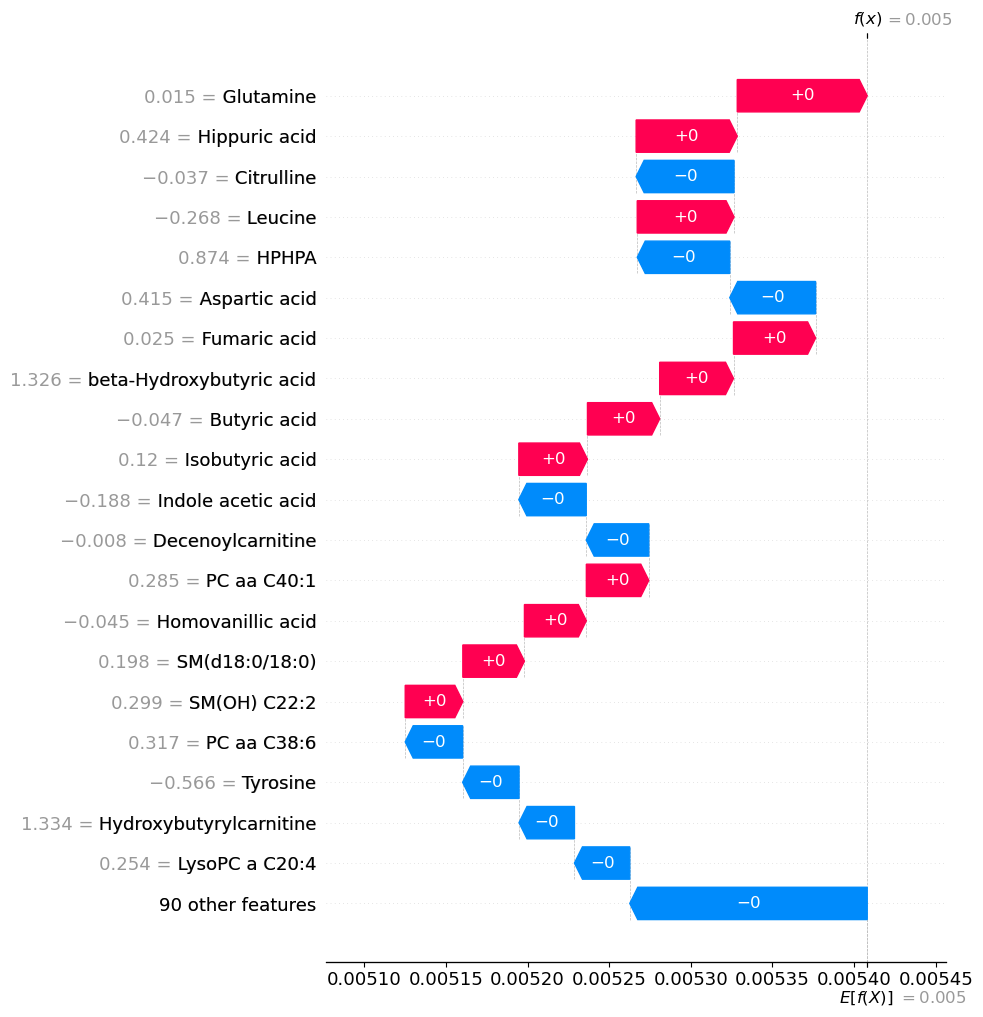

In [ ]:
# Use explanation function to explain feature contributions to class 0: Control
explanation_p_0 = shap.Explanation(shap_values_p[:, :, 0], feature_names=metabolite_names)
shap.waterfall_plot(explanation_p_0.mean(0), max_display=21)

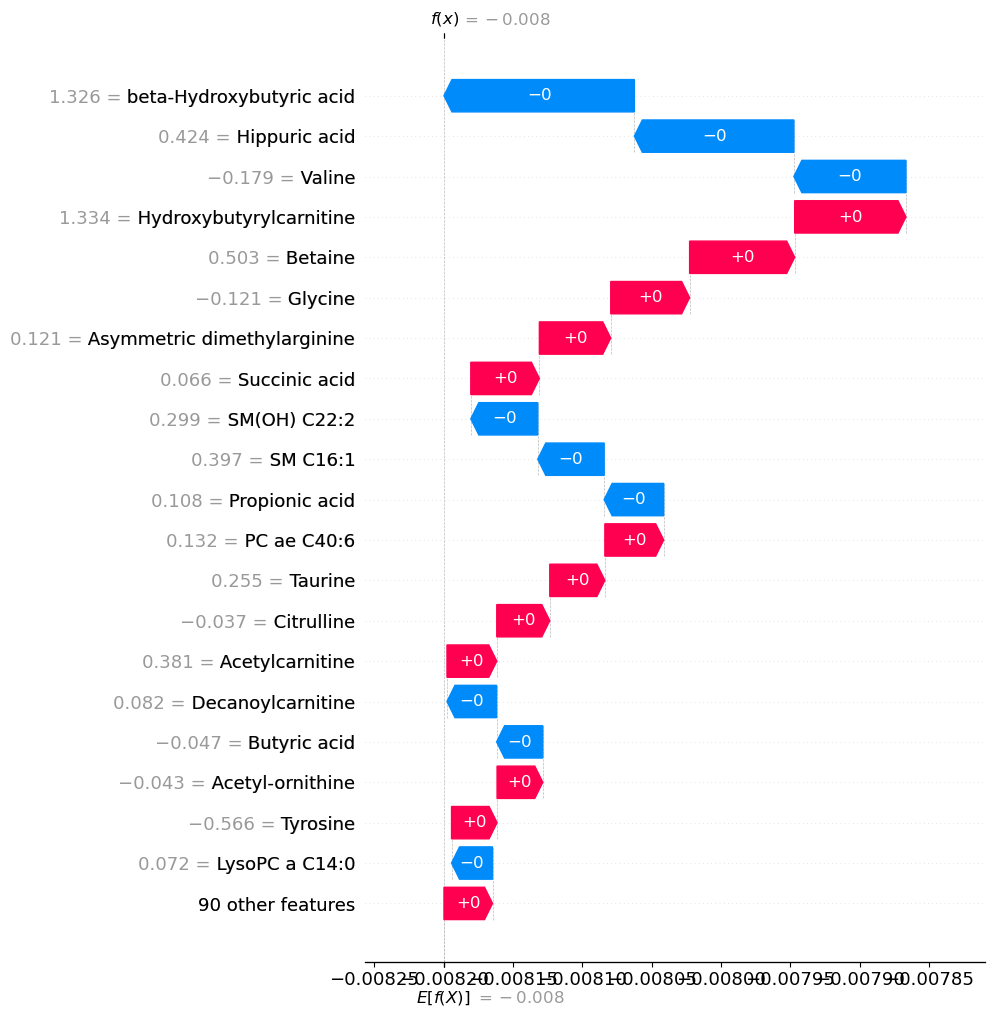

In [ ]:
# Use explanation function to explain feature contributions to class 0: Covid
explanation_p_1 = shap.Explanation(shap_values_p[:, :, 1], feature_names=metabolite_names)
shap.waterfall_plot(explanation_p_1.mean(0), max_display=21)

## Case vs Control
- Now we compare case (covid) vales vs control values
- In a dataframe, we will have the metabolites, the mean values for control and covid accross samples
- Our biomarkers are those which have high absolute mean SHAP value for Covid but not for Control
- So we calculate the asbolute difference and plot the one with top 20

In [ ]:
# Create a dataframe of mean shap values with metabolite names for ease of plotting
shap_data = pd.DataFrame({
    'Metabolite': metabolite_names,
    'Control': explanation_p_0.mean(0).values,
    'Covid': explanation_p_1.mean(0).values
})
# Calculate the absolute difference between covid values and control values
shap_data['Difference'] = abs(shap_data['Covid'] - shap_data['Control'])

In [ ]:
# Sort the values and get top 20 based on difference
high_covid_biomarkers = shap_data.sort_values(by='Difference', ascending=False).head(20)
high_covid_biomarkers = high_covid_biomarkers.sort_values(by='Covid')

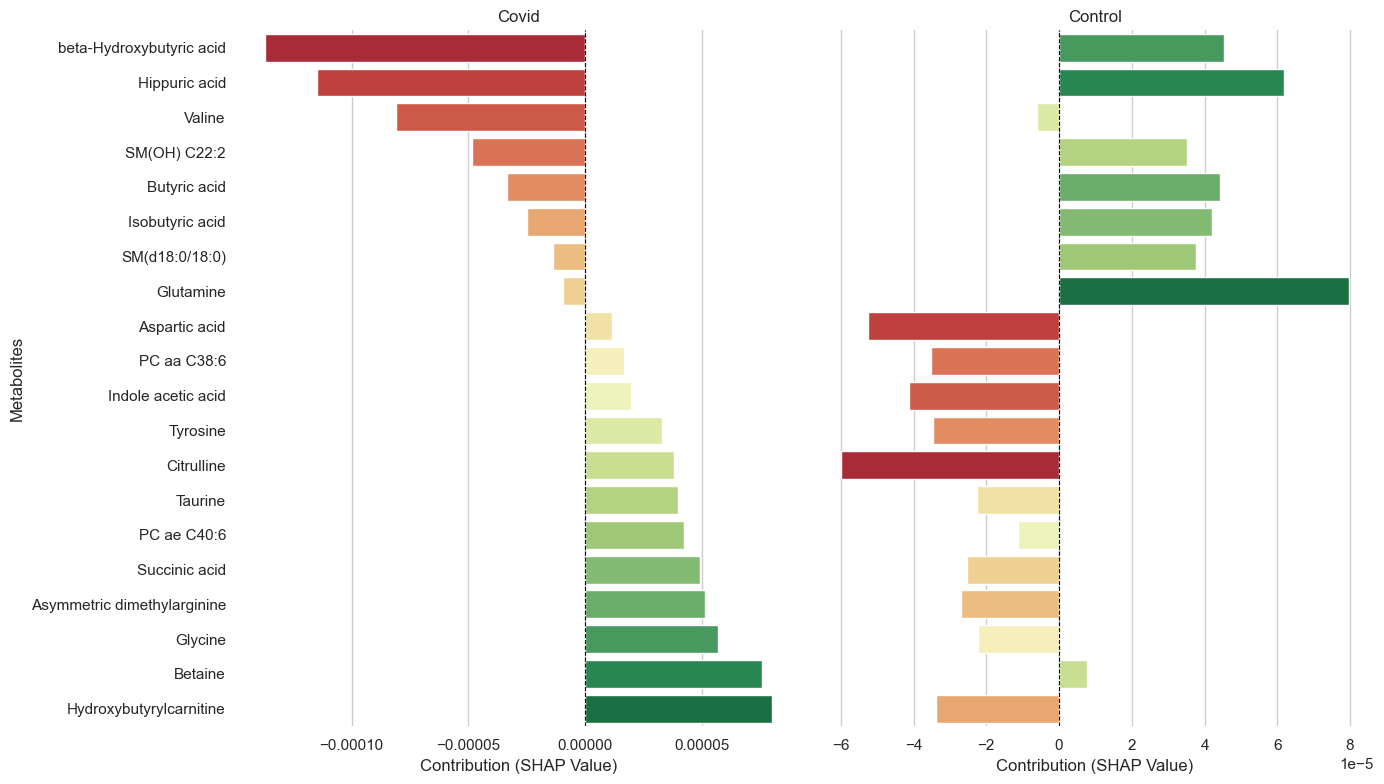

In [505]:
sns.set_theme(style="whitegrid", color_codes=True)

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

pal = sns.color_palette("RdYlGn", len(high_covid_biomarkers))

# Plot Covid Contributions with color gradient
sns.barplot(
    x=high_covid_biomarkers['Covid'],
    y=high_covid_biomarkers['Metabolite'],
    palette=pal,
    hue = high_covid_biomarkers['Covid'],
    ax=ax1,
    legend = False
)
ax1.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax1.set_title("Covid", fontsize=12)
ax1.set_xlabel("Contribution (SHAP Value)", fontsize=12)
ax1.set_ylabel("Metabolites", fontsize=12)

# Plot Control Contributions
sns.barplot(
    x=high_covid_biomarkers['Control'],
    y=high_covid_biomarkers['Metabolite'],
    palette=pal,
    hue = high_covid_biomarkers['Control'],
    ax=ax2,
    legend = False
)
ax2.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax2.set_title("Control", fontsize=12)
ax2.set_xlabel("Contribution (SHAP Value)", fontsize=12)
ax2.set_ylabel("")


# Finalize the plot
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Show the plot
plt.show()

## Further Analysis

In [555]:
covid_metabolites = pd.read_csv('../data/covid19_metabolites.csv')

top_metabolites = list(high_covid_biomarkers['Metabolite'])

# Filter covid_metabolites for only the top metabolites
filtered_data = covid_metabolites[top_metabolites]

 # Add the Group column
filtered_data['Group'] = covid_metabolites['Group'] 

# Rearrange columns to place 'Group' first (optional)
filtered_data = filtered_data[['Group'] + top_metabolites]

/var/folders/n8/b6_h9cbd1r3fjkr_2zjs39qw0000gn/T/ipykernel_7715/2029075016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Group'] = covid_metabolites['Group']


### Heatmap

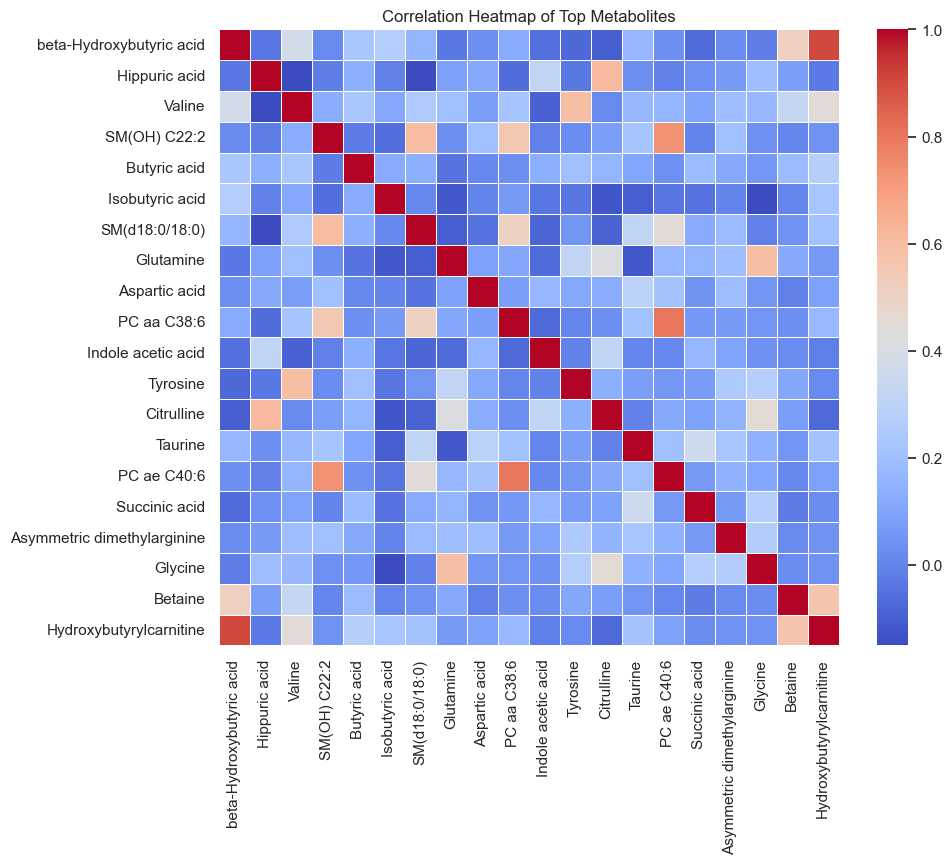

In [556]:
corr = filtered_data[top_metabolites].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Correlation Heatmap of Top Metabolites")
plt.show()

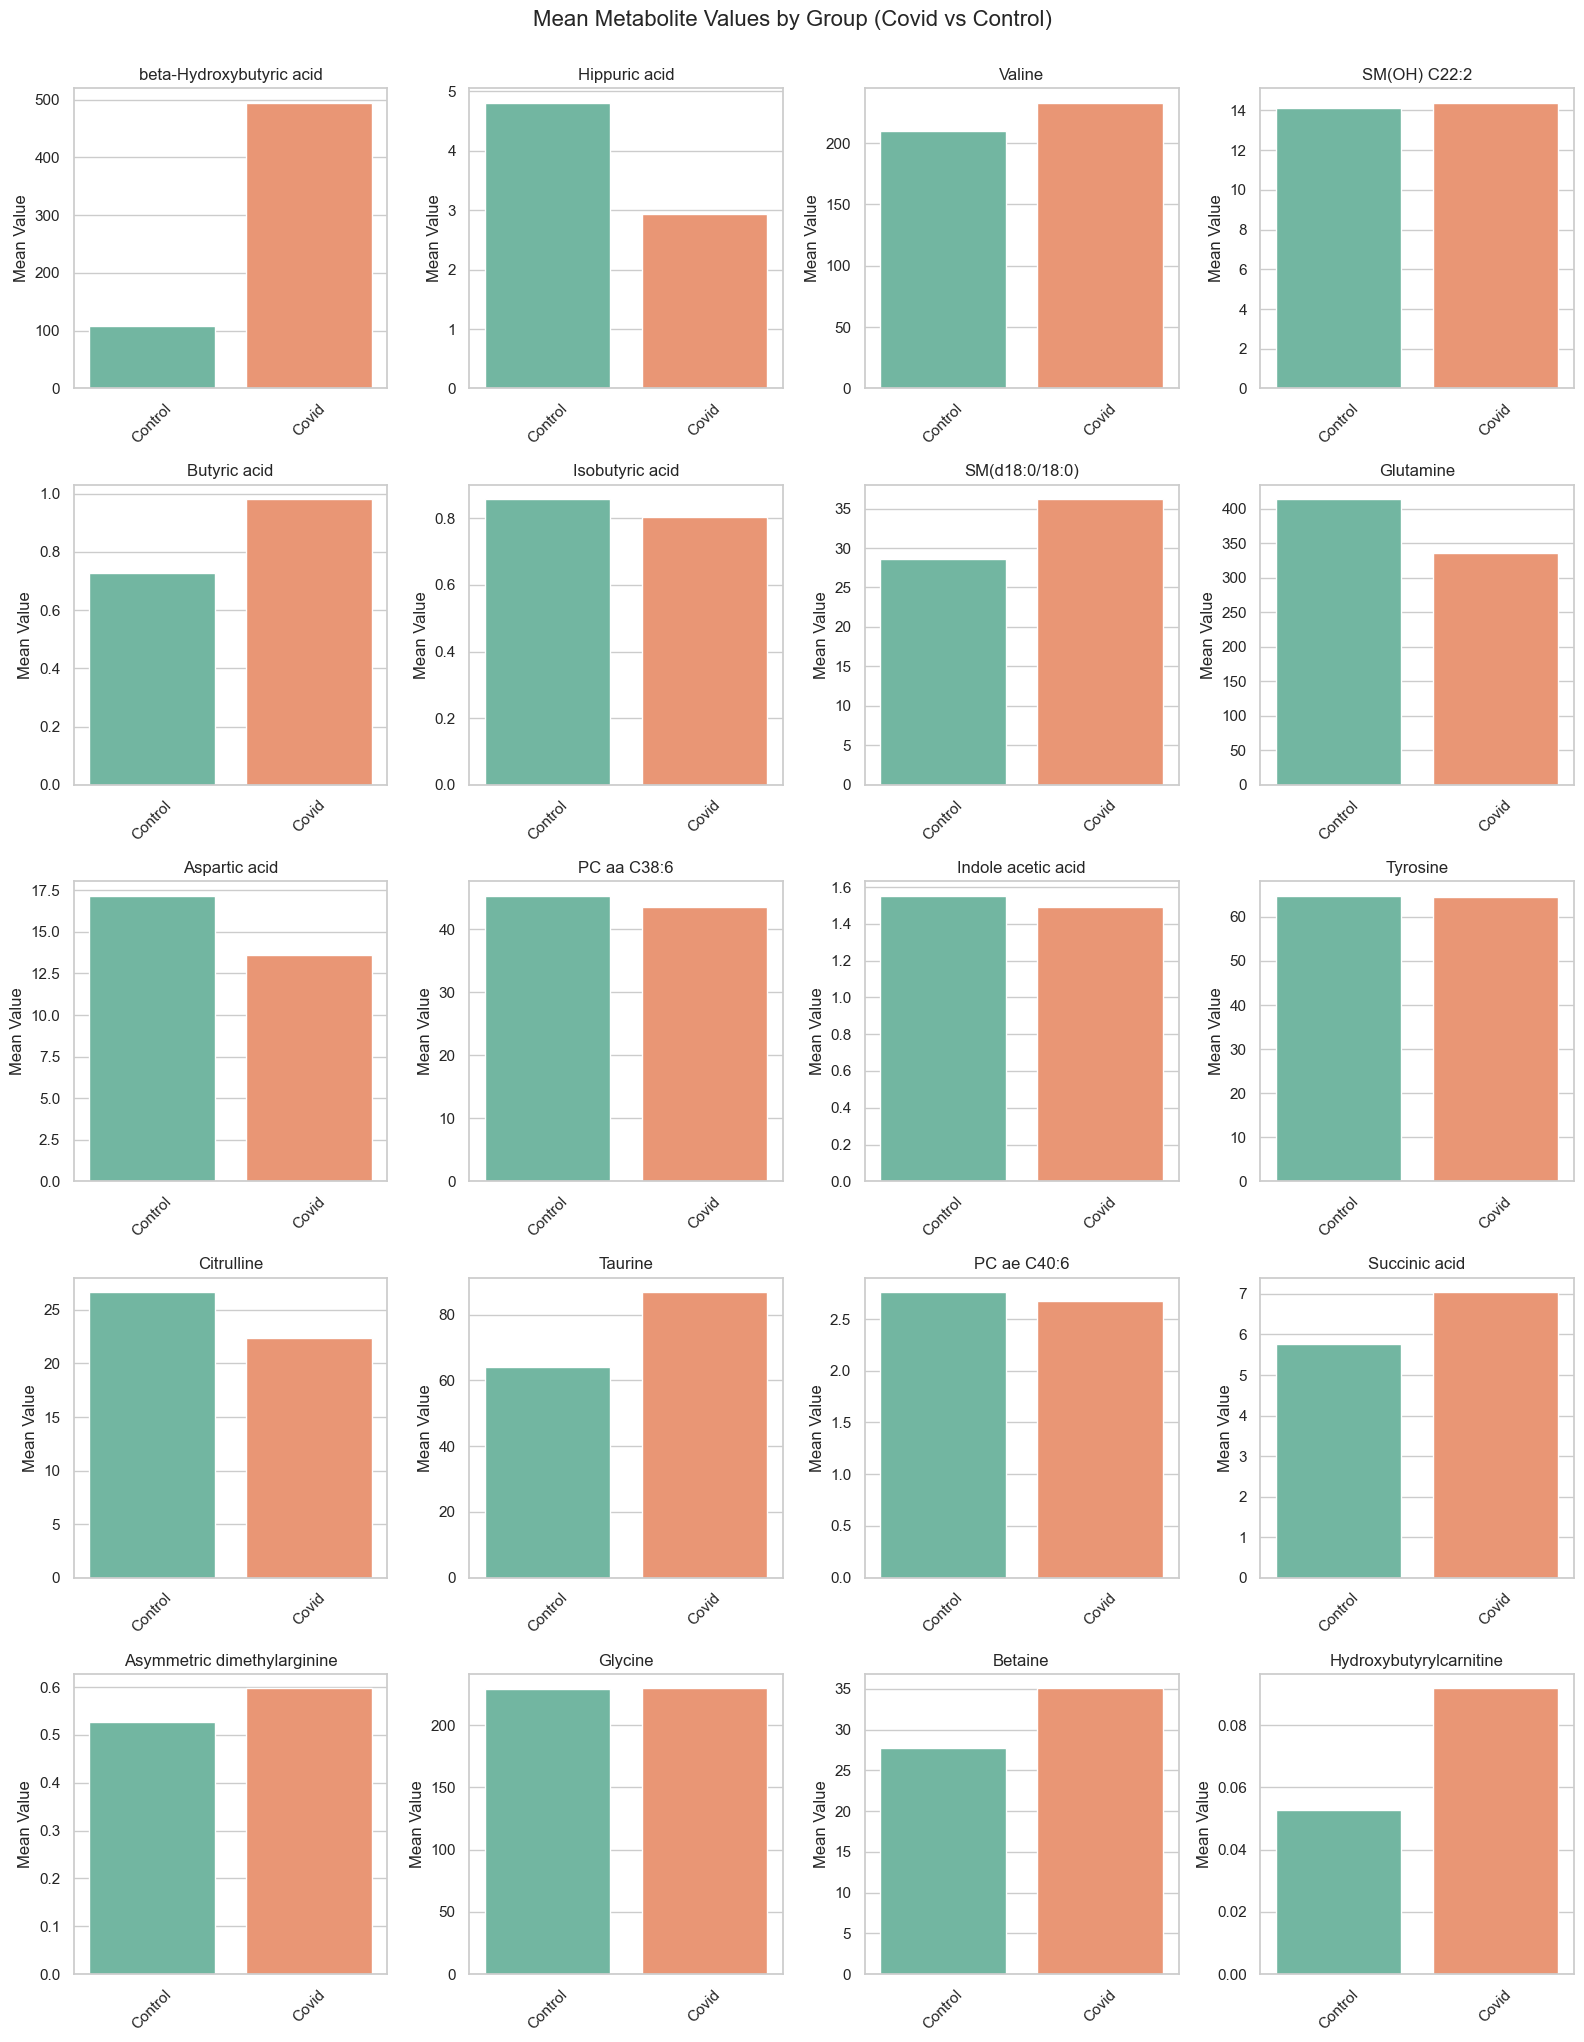

In [ ]:
# Compute mean values for each metabolite, grouped by "Group"
mean_values = filtered_data.groupby("Group").mean().reset_index()
mean_values = mean_values.melt(id_vars="Group", var_name="Metabolite", value_name="Mean Value")

plt.figure(figsize=(16, 20))
for i, metabolite in enumerate(top_metabolites, 1):
    plt.subplot(5, 4, i)  # 5 rows, 4 columns
    sns.barplot(
        data=mean_values[mean_values["Metabolite"] == metabolite],
        x="Group",
        y="Mean Value",
        palette="Set2",
        hue = mean_values['Group'],
        legend = False
    )
    plt.title(metabolite, fontsize=12)
    plt.xlabel("")
    plt.ylabel("Mean Value")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("Mean Metabolite Values by Group (Covid vs Control)", fontsize=16, y=1.02)
plt.show()

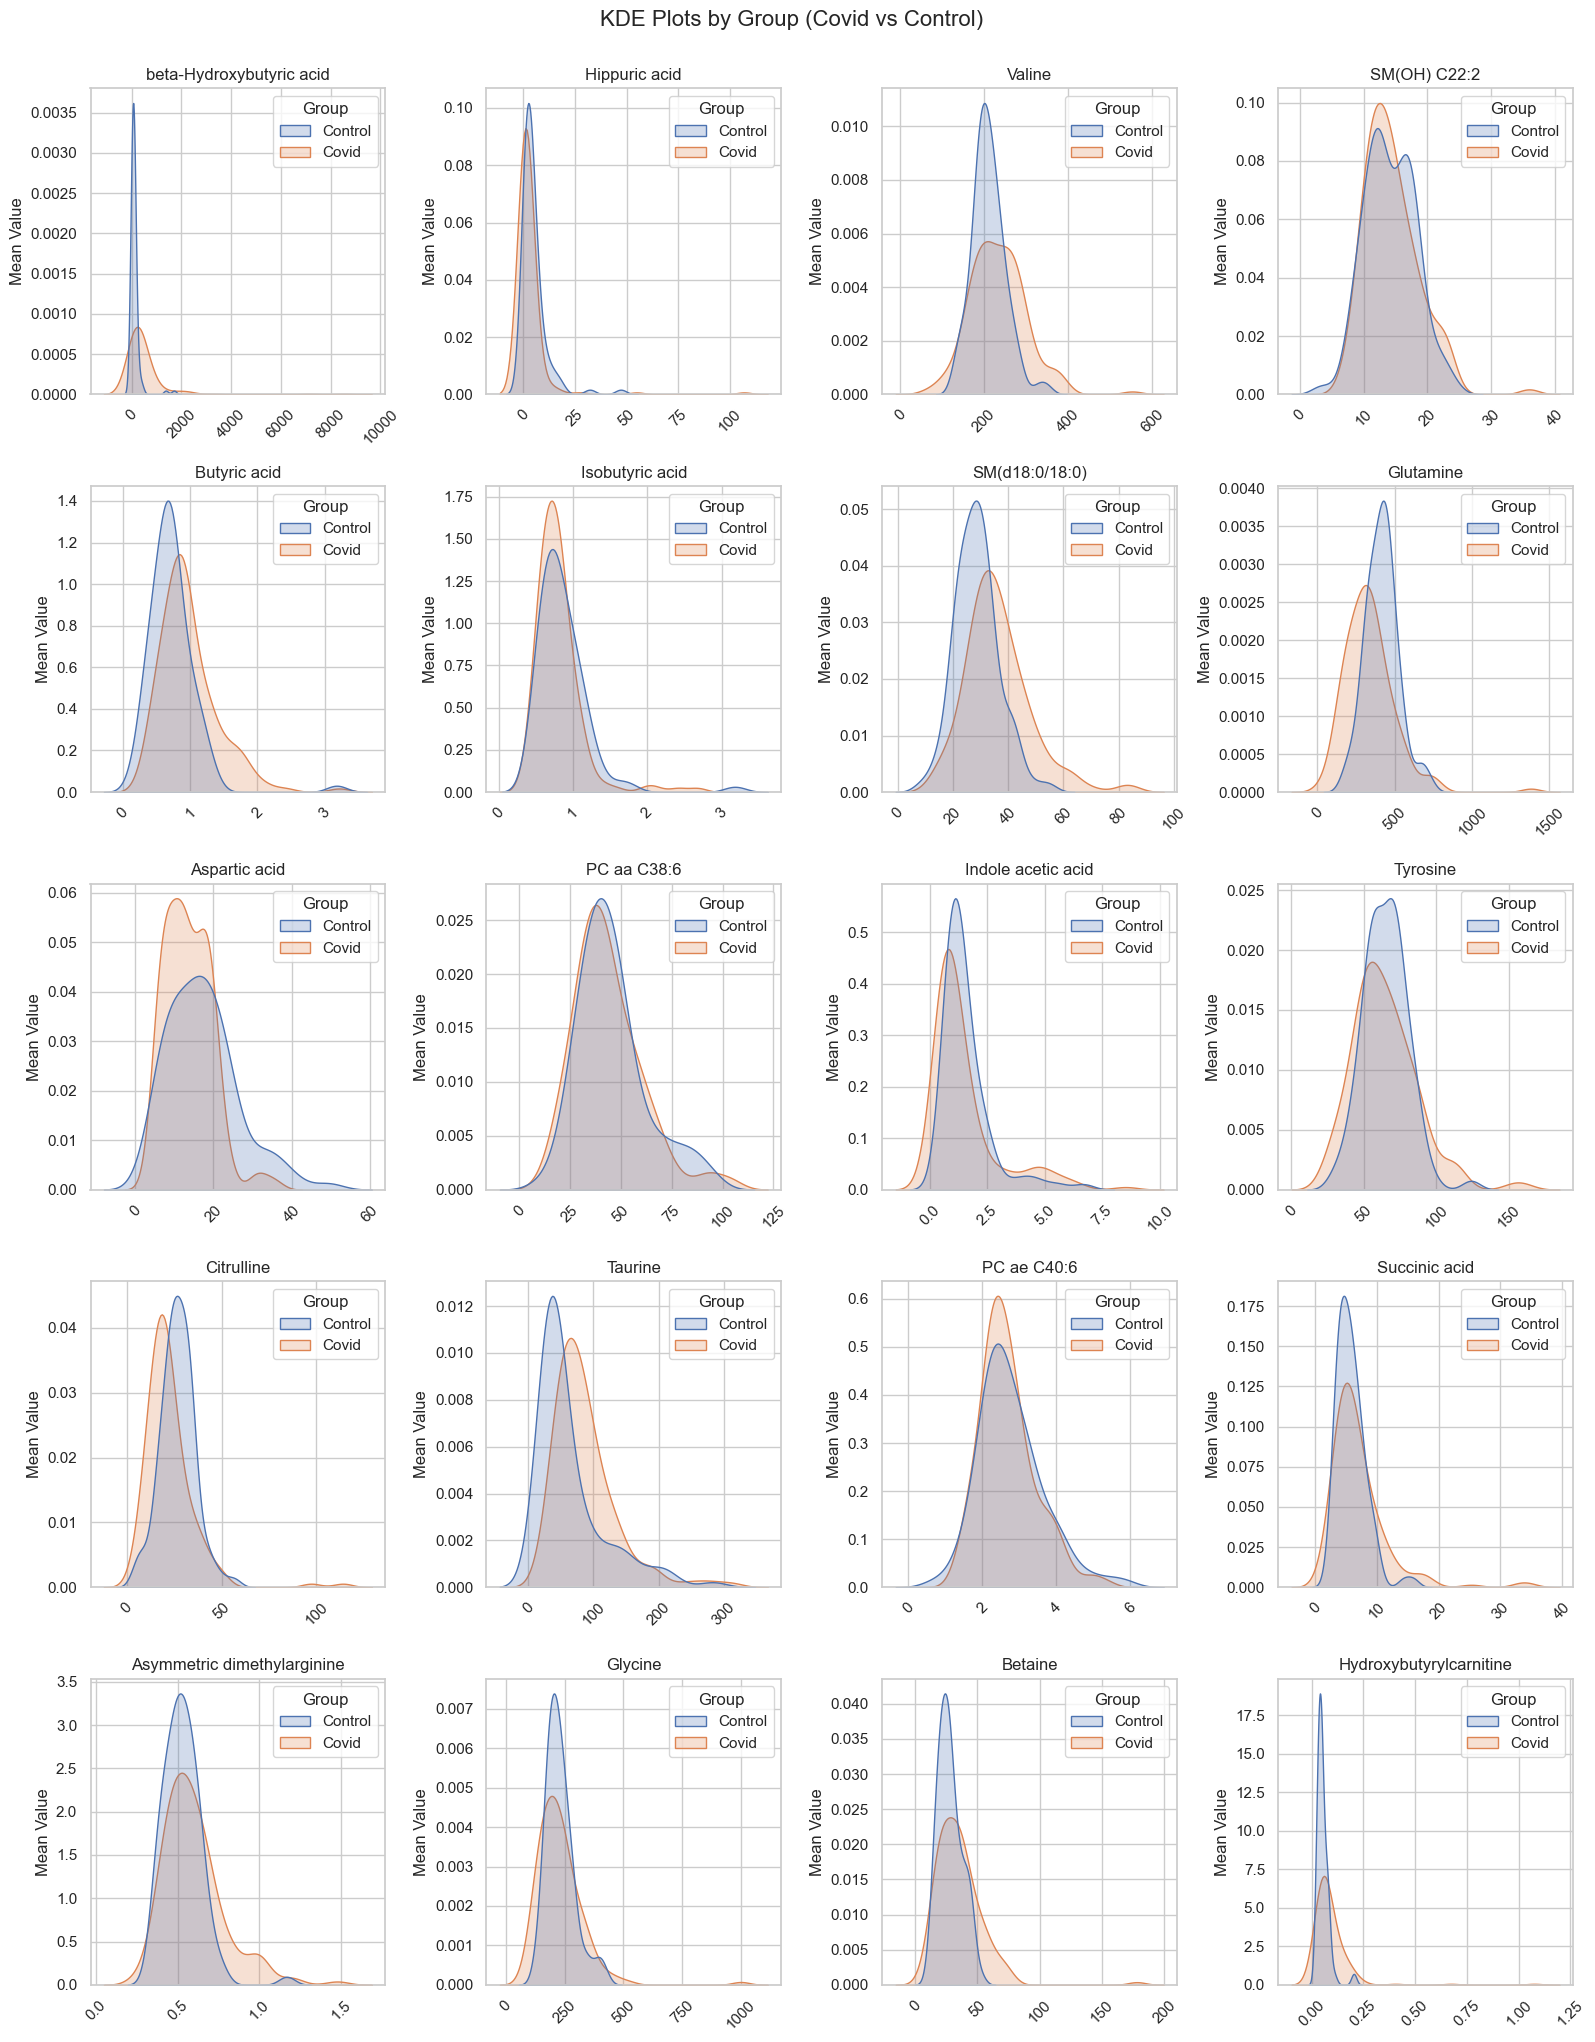

In [563]:
plt.figure(figsize=(16, 20))
for i, metabolite in enumerate(top_metabolites, 1):
    plt.subplot(5, 4, i)  # 5 rows, 4 columns
    sns.kdeplot(data=covid_metabolites, x=metabolite, hue="Group", fill=True, common_norm=False)
    plt.title(metabolite, fontsize=12)
    plt.xlabel("")
    plt.ylabel("Mean Value")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle("KDE Plots by Group (Covid vs Control)", fontsize=16, y=1.02)
plt.show()